In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import gc
gc.collect()

%matplotlib inline
pd.options.display.max_columns=1000
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [2]:
PATH_TRAIN="train- Capillary 4/train.csv"
PATH_PROD="train- Capillary 4/product_attributes.csv"
PATH_TEST="test_nFNPSyV.csv"
USER_ID_COL="UserId"
PROD_ID_COL="productid"
DATE_COL="OrderDate"

In [3]:
train_df = pd.read_csv(PATH_TRAIN,parse_dates=[DATE_COL],dayfirst=True)
print(train_df.shape)
train_df.head()

(132551, 4)


,UserId,productid,Quantity,OrderDate
0,18075,12322648,1,2018-04-01
1,6820,12371370,1,2018-04-01
2,6820,12973004,1,2018-04-01
3,6820,12657560,1,2018-04-01
4,6820,11659914,1,2018-04-01


In [4]:
test_df = pd.read_csv(PATH_TEST)
print(test_df.shape)
test_df.head()

(2350, 1)


,UserId
0,2
1,28
2,36
3,38
4,41


In [5]:
prod_df = pd.read_csv(PATH_PROD)
print(prod_df.shape)
prod_df.head()

(18750, 3)


,productid,attribute_name,attributevalue
0,11145600,Fit,37
1,11145600,Sleeve Length,23
2,11145600,Fabric,16
3,11145600,Color,25
4,11145600,Neckline,51


In [6]:
train_df = train_df.sort_values([USER_ID_COL,PROD_ID_COL,"Quantity"],ascending=[True,True,False])
train_df = train_df.groupby([USER_ID_COL,PROD_ID_COL])["Quantity"].sum().reset_index()
train_df = train_df.sort_values([USER_ID_COL,"Quantity"],ascending=[True,False])
train_df.head(10)

,UserId,productid,Quantity
0,0,11659624,1
1,1,12406904,1
2,2,11660064,1
3,3,12360440,3
4,3,12371354,3
5,3,12407298,3
6,3,12407522,3
7,3,12407616,3
8,3,12658228,3
9,4,11659934,1


In [7]:
prod_df = prod_df.pivot_table('attributevalue', ['productid'], 'attribute_name',fill_value=-1).reset_index()
prod_df.head(10)

attribute_name,productid,Category,Collection,Color,Fabric,Fit,Material,Neckline,Season,Sleeve Length
0,11139192,1,-1,41.0,2.0,0,-1,-1.0,42,-1
1,11139194,1,-1,25.0,2.0,0,-1,-1.0,42,-1
2,11139524,1,-1,95.0,16.0,14,-1,4.0,42,23
3,11139560,1,-1,41.0,2.0,14,-1,4.0,42,127
4,11139588,1,-1,25.0,58.0,0,-1,-1.0,42,-1
5,11139650,1,-1,31.0,2.0,14,-1,4.0,42,23
6,11141306,1,-1,28.0,2.0,-1,-1,-1.0,56,-1
7,11141308,1,-1,71.0,2.0,0,-1,-1.0,56,-1
8,11141318,1,-1,149.0,2.0,0,-1,-1.0,56,-1
9,11141320,1,-1,149.0,2.0,0,-1,-1.0,56,-1


In [8]:
train_df = pd.merge(train_df,prod_df,how="left")

In [9]:
train_df.head(10)

,UserId,productid,Quantity,Category,Collection,Color,Fabric,Fit,Material,Neckline,Season,Sleeve Length
0,0,11659624,1,7.0,-1.0,32.0,27.0,0.0,-1.0,8.0,11.0,3.0
1,1,12406904,1,1.0,-1.0,18.0,2.0,0.0,-1.0,8.0,5.0,3.0
2,2,11660064,1,12.0,-1.0,84.0,55.0,14.0,-1.0,4.0,11.0,23.0
3,3,12360440,3,7.0,-1.0,123.0,39.0,0.0,-1.0,4.0,5.0,3.0
4,3,12371354,3,1.0,-1.0,17.0,2.0,-1.0,-1.0,-1.0,5.0,-1.0
5,3,12407298,3,1.0,-1.0,17.0,46.0,-1.0,-1.0,-1.0,5.0,-1.0
6,3,12407522,3,1.0,-1.0,22.0,10.0,14.0,-1.0,4.0,5.0,3.0
7,3,12407616,3,1.0,-1.0,22.0,46.0,0.0,-1.0,4.0,5.0,3.0
8,3,12658228,3,7.0,-1.0,20.0,33.0,0.0,-1.0,8.0,6.0,3.0
9,4,11659934,1,1.0,-1.0,20.0,10.0,14.0,-1.0,4.0,5.0,3.0


In [10]:
train_df.fillna(-99,inplace=True)

In [11]:
print(test_df.UserId.nunique())
print(prod_df.productid.nunique())

2350
3015


In [12]:
2350*3015

7085250

In [13]:
test_df["key"] = 1
prod_df["key"] = 1
test_df = pd.merge(test_df,prod_df,on="key")
test_df.shape

(7085250, 12)

In [14]:
test_df.drop("key",axis=1,inplace=True)
test_df.head()

,UserId,productid,Category,Collection,Color,Fabric,Fit,Material,Neckline,Season,Sleeve Length
0,2,11139192,1,-1,41.0,2.0,0,-1,-1.0,42,-1
1,2,11139194,1,-1,25.0,2.0,0,-1,-1.0,42,-1
2,2,11139524,1,-1,95.0,16.0,14,-1,4.0,42,23
3,2,11139560,1,-1,41.0,2.0,14,-1,4.0,42,127
4,2,11139588,1,-1,25.0,58.0,0,-1,-1.0,42,-1


In [15]:
#train_df.columns
x_col = ['UserId', 'productid', 'Category', 'Collection', 'Color',
         'Fabric', 'Fit', 'Material', 'Neckline', 'Season', 'Sleeve Length']
train_X = train_df[x_col]
train_y = train_df["Quantity"].values
test_X = test_df[x_col]


In [16]:
gc.collect()

137

In [17]:
train_df.shape

(74915, 12)

In [18]:
#unique users in train
train_df[USER_ID_COL].nunique()

27778

In [19]:
def runLGB(train_X, train_y, test_X, test_y=None,categorical_feature='auto'): 
    params = {}
    params["objective"] = "regression"
    params['metric'] = 'rmse'
    params["max_depth"] = 12 # -1 means no limit
    params['num_leaves'] = 70   # we should let it be smaller than 2^(max_depth). Around 0.7 to 0.8
    params["min_data_in_leaf"] = 100 #Aka min_data.  constraints: min_data_in_leaf >= 0
    #params["max_bin"] = 255 #default = 255, type = int, constraints: max_bin > 1. small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)
    params["learning_rate"] = 0.01
   # params["subsample"] = 0.9  # Subsample ratio of the training instance. Aka bagging_fraction
    #params["feature_fraction"] = 0.7
   # params["bagging_freq"] = 5 #0 = disable bagging. To enable bagging, bagging_fraction should be set to value smaller than 1.0
   # params["bagging_seed"] = 0
    #params["min_split_gain"] = 0  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    #params["reg_alpha"] = 0  # L1 regularization term on weights
    #params["reg_lambda"] = 0  # L2 regularization term on weights
    #params["verbosity"] = 100 #Aka verbose. < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug
    num_rounds = 1000
    
    lgtrain = lgb.Dataset(train_X, label=train_y, categorical_feature=categorical_feature)

    if test_y is not None:
        evals_result = {}  # to record eval results for plotting
        lgtest = lgb.Dataset(test_X, label=test_y,categorical_feature=categorical_feature)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtrain,lgtest],
                          early_stopping_rounds=100,
                          evals_result=evals_result)
        
        print('Plotting metrics recorded during training...')
        ax = lgb.plot_metric(evals_result, metric=params['metric'])
        plt.show()
    else:
        lgtest = lgb.Dataset(test_X, categorical_feature=categorical_feature)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_dev =  model.predict(train_X, num_iteration=model.best_iteration)   
    pred_test = model.predict(test_X, num_iteration=model.best_iteration)
    
    return pred_dev, pred_test, model

In [20]:
gc.collect()

0

[1]	training's rmse: 5.20673	valid_1's rmse: 1.1034
Training until validation scores don't improve for 100 rounds.
[2]	training's rmse: 5.18065	valid_1's rmse: 1.09945
[3]	training's rmse: 5.15497	valid_1's rmse: 1.09556
[4]	training's rmse: 5.12968	valid_1's rmse: 1.09175
[5]	training's rmse: 5.10477	valid_1's rmse: 1.08799
[6]	training's rmse: 5.08023	valid_1's rmse: 1.08431
[7]	training's rmse: 5.05607	valid_1's rmse: 1.08068
[8]	training's rmse: 5.03227	valid_1's rmse: 1.07712
[9]	training's rmse: 5.00883	valid_1's rmse: 1.07362
[10]	training's rmse: 4.98576	valid_1's rmse: 1.07033
[11]	training's rmse: 4.96304	valid_1's rmse: 1.06695
[12]	training's rmse: 4.94066	valid_1's rmse: 1.06435
[13]	training's rmse: 4.91864	valid_1's rmse: 1.06181
[14]	training's rmse: 4.89695	valid_1's rmse: 1.05923
[15]	training's rmse: 4.87561	valid_1's rmse: 1.05606
[16]	training's rmse: 4.8546	valid_1's rmse: 1.05366
[17]	training's rmse: 4.83392	valid_1's rmse: 1.05129
[18]	training's rmse: 4.81356	

[158]	training's rmse: 3.70127	valid_1's rmse: 0.918227
[159]	training's rmse: 3.69888	valid_1's rmse: 0.917978
[160]	training's rmse: 3.69682	valid_1's rmse: 0.917728
[161]	training's rmse: 3.69476	valid_1's rmse: 0.917466
[162]	training's rmse: 3.69246	valid_1's rmse: 0.917206
[163]	training's rmse: 3.69023	valid_1's rmse: 0.917084
[164]	training's rmse: 3.68829	valid_1's rmse: 0.916854
[165]	training's rmse: 3.6861	valid_1's rmse: 0.916625
[166]	training's rmse: 3.68423	valid_1's rmse: 0.916384
[167]	training's rmse: 3.6824	valid_1's rmse: 0.916171
[168]	training's rmse: 3.68031	valid_1's rmse: 0.916071
[169]	training's rmse: 3.67826	valid_1's rmse: 0.91584
[170]	training's rmse: 3.67652	valid_1's rmse: 0.915636
[171]	training's rmse: 3.67452	valid_1's rmse: 0.915421
[172]	training's rmse: 3.67283	valid_1's rmse: 0.915225
[173]	training's rmse: 3.67089	valid_1's rmse: 0.915034
[174]	training's rmse: 3.6692	valid_1's rmse: 0.91468
[175]	training's rmse: 3.66732	valid_1's rmse: 0.9144

[309]	training's rmse: 3.52673	valid_1's rmse: 0.90788
[310]	training's rmse: 3.52618	valid_1's rmse: 0.907858
[311]	training's rmse: 3.52552	valid_1's rmse: 0.907836
[312]	training's rmse: 3.52494	valid_1's rmse: 0.907892
[313]	training's rmse: 3.52429	valid_1's rmse: 0.907868
[314]	training's rmse: 3.52378	valid_1's rmse: 0.907869
[315]	training's rmse: 3.52314	valid_1's rmse: 0.90785
[316]	training's rmse: 3.52257	valid_1's rmse: 0.907853
[317]	training's rmse: 3.52194	valid_1's rmse: 0.907827
[318]	training's rmse: 3.5211	valid_1's rmse: 0.907814
[319]	training's rmse: 3.52054	valid_1's rmse: 0.907942
[320]	training's rmse: 3.52003	valid_1's rmse: 0.907929
[321]	training's rmse: 3.51942	valid_1's rmse: 0.907917
[322]	training's rmse: 3.51862	valid_1's rmse: 0.907895
[323]	training's rmse: 3.51807	valid_1's rmse: 0.907766
[324]	training's rmse: 3.51752	valid_1's rmse: 0.907771
[325]	training's rmse: 3.51673	valid_1's rmse: 0.907754
[326]	training's rmse: 3.51621	valid_1's rmse: 0.90

[467]	training's rmse: 3.45135	valid_1's rmse: 0.905999
[468]	training's rmse: 3.45101	valid_1's rmse: 0.905994
[469]	training's rmse: 3.45081	valid_1's rmse: 0.906014
[470]	training's rmse: 3.45058	valid_1's rmse: 0.905969
[471]	training's rmse: 3.45022	valid_1's rmse: 0.905969
[472]	training's rmse: 3.45002	valid_1's rmse: 0.905981
[473]	training's rmse: 3.44966	valid_1's rmse: 0.905981
[474]	training's rmse: 3.44949	valid_1's rmse: 0.905972
[475]	training's rmse: 3.44924	valid_1's rmse: 0.905988
[476]	training's rmse: 3.44904	valid_1's rmse: 0.905997
[477]	training's rmse: 3.44876	valid_1's rmse: 0.905999
[478]	training's rmse: 3.44859	valid_1's rmse: 0.905987
[479]	training's rmse: 3.44842	valid_1's rmse: 0.905998
[480]	training's rmse: 3.44807	valid_1's rmse: 0.905998
[481]	training's rmse: 3.44787	valid_1's rmse: 0.906022
[482]	training's rmse: 3.4476	valid_1's rmse: 0.906023
[483]	training's rmse: 3.44732	valid_1's rmse: 0.906034
[484]	training's rmse: 3.44709	valid_1's rmse: 0.

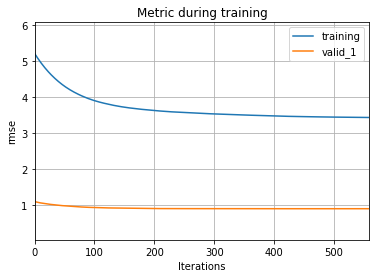

[1]	training's rmse: 5.20373	valid_1's rmse: 1.15799
Training until validation scores don't improve for 100 rounds.
[2]	training's rmse: 5.17762	valid_1's rmse: 1.15408
[3]	training's rmse: 5.15191	valid_1's rmse: 1.15021
[4]	training's rmse: 5.12657	valid_1's rmse: 1.14643
[5]	training's rmse: 5.10161	valid_1's rmse: 1.14272
[6]	training's rmse: 5.07704	valid_1's rmse: 1.13907
[7]	training's rmse: 5.05283	valid_1's rmse: 1.13549
[8]	training's rmse: 5.02899	valid_1's rmse: 1.13197
[9]	training's rmse: 5.00552	valid_1's rmse: 1.12851
[10]	training's rmse: 4.98241	valid_1's rmse: 1.1251
[11]	training's rmse: 4.95965	valid_1's rmse: 1.12177
[12]	training's rmse: 4.93724	valid_1's rmse: 1.1185
[13]	training's rmse: 4.91518	valid_1's rmse: 1.11527
[14]	training's rmse: 4.89346	valid_1's rmse: 1.11208
[15]	training's rmse: 4.87209	valid_1's rmse: 1.10899
[16]	training's rmse: 4.85104	valid_1's rmse: 1.10596
[17]	training's rmse: 4.83032	valid_1's rmse: 1.10299
[18]	training's rmse: 4.80993	

[159]	training's rmse: 3.69615	valid_1's rmse: 0.967259
[160]	training's rmse: 3.69388	valid_1's rmse: 0.967138
[161]	training's rmse: 3.69174	valid_1's rmse: 0.967019
[162]	training's rmse: 3.68956	valid_1's rmse: 0.966882
[163]	training's rmse: 3.68756	valid_1's rmse: 0.966771
[164]	training's rmse: 3.68529	valid_1's rmse: 0.966665
[165]	training's rmse: 3.68306	valid_1's rmse: 0.966561
[166]	training's rmse: 3.68088	valid_1's rmse: 0.966463
[167]	training's rmse: 3.67899	valid_1's rmse: 0.966342
[168]	training's rmse: 3.67685	valid_1's rmse: 0.966249
[169]	training's rmse: 3.67504	valid_1's rmse: 0.966156
[170]	training's rmse: 3.67295	valid_1's rmse: 0.966064
[171]	training's rmse: 3.67093	valid_1's rmse: 0.965972
[172]	training's rmse: 3.66911	valid_1's rmse: 0.965866
[173]	training's rmse: 3.66713	valid_1's rmse: 0.965787
[174]	training's rmse: 3.66531	valid_1's rmse: 0.965705
[175]	training's rmse: 3.6634	valid_1's rmse: 0.965594
[176]	training's rmse: 3.66163	valid_1's rmse: 0.

[314]	training's rmse: 3.51808	valid_1's rmse: 0.964092
[315]	training's rmse: 3.51739	valid_1's rmse: 0.964094
[316]	training's rmse: 3.51683	valid_1's rmse: 0.964106
[317]	training's rmse: 3.51608	valid_1's rmse: 0.964114
[318]	training's rmse: 3.51553	valid_1's rmse: 0.964126
[319]	training's rmse: 3.51479	valid_1's rmse: 0.964153
[320]	training's rmse: 3.51425	valid_1's rmse: 0.964161
[321]	training's rmse: 3.51353	valid_1's rmse: 0.964163
[322]	training's rmse: 3.513	valid_1's rmse: 0.964174
[323]	training's rmse: 3.51231	valid_1's rmse: 0.964184
[324]	training's rmse: 3.51161	valid_1's rmse: 0.964199
[325]	training's rmse: 3.51096	valid_1's rmse: 0.96421
[326]	training's rmse: 3.51045	valid_1's rmse: 0.964219
[327]	training's rmse: 3.50983	valid_1's rmse: 0.964227
[328]	training's rmse: 3.50916	valid_1's rmse: 0.964236
[329]	training's rmse: 3.50867	valid_1's rmse: 0.964249
[330]	training's rmse: 3.50799	valid_1's rmse: 0.964257
[331]	training's rmse: 3.50737	valid_1's rmse: 0.96

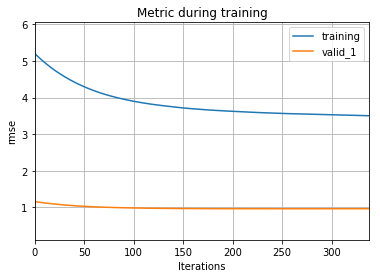

[1]	training's rmse: 5.20253	valid_1's rmse: 1.18402
Training until validation scores don't improve for 100 rounds.
[2]	training's rmse: 5.17643	valid_1's rmse: 1.18053
[3]	training's rmse: 5.15072	valid_1's rmse: 1.17709
[4]	training's rmse: 5.1254	valid_1's rmse: 1.17372
[5]	training's rmse: 5.10045	valid_1's rmse: 1.17013
[6]	training's rmse: 5.07589	valid_1's rmse: 1.16666
[7]	training's rmse: 5.0517	valid_1's rmse: 1.16344
[8]	training's rmse: 5.02787	valid_1's rmse: 1.15996
[9]	training's rmse: 5.00441	valid_1's rmse: 1.15665
[10]	training's rmse: 4.98131	valid_1's rmse: 1.15328
[11]	training's rmse: 4.95856	valid_1's rmse: 1.15038
[12]	training's rmse: 4.93616	valid_1's rmse: 1.14713
[13]	training's rmse: 4.91411	valid_1's rmse: 1.14407
[14]	training's rmse: 4.8924	valid_1's rmse: 1.14104
[15]	training's rmse: 4.87103	valid_1's rmse: 1.13835
[16]	training's rmse: 4.84999	valid_1's rmse: 1.13561
[17]	training's rmse: 4.82928	valid_1's rmse: 1.1327
[18]	training's rmse: 4.8089	val

[159]	training's rmse: 3.6946	valid_1's rmse: 0.982986
[160]	training's rmse: 3.69247	valid_1's rmse: 0.982766
[161]	training's rmse: 3.69002	valid_1's rmse: 0.98255
[162]	training's rmse: 3.68803	valid_1's rmse: 0.982268
[163]	training's rmse: 3.68567	valid_1's rmse: 0.982051
[164]	training's rmse: 3.68341	valid_1's rmse: 0.981838
[165]	training's rmse: 3.68145	valid_1's rmse: 0.981627
[166]	training's rmse: 3.67917	valid_1's rmse: 0.98143
[167]	training's rmse: 3.67701	valid_1's rmse: 0.98123
[168]	training's rmse: 3.67523	valid_1's rmse: 0.981046
[169]	training's rmse: 3.67305	valid_1's rmse: 0.980796
[170]	training's rmse: 3.67121	valid_1's rmse: 0.980634
[171]	training's rmse: 3.66917	valid_1's rmse: 0.980462
[172]	training's rmse: 3.66741	valid_1's rmse: 0.980289
[173]	training's rmse: 3.66535	valid_1's rmse: 0.980128
[174]	training's rmse: 3.66352	valid_1's rmse: 0.979979
[175]	training's rmse: 3.66163	valid_1's rmse: 0.979816
[176]	training's rmse: 3.6598	valid_1's rmse: 0.9795

[321]	training's rmse: 3.51161	valid_1's rmse: 0.97187
[322]	training's rmse: 3.51083	valid_1's rmse: 0.971859
[323]	training's rmse: 3.51023	valid_1's rmse: 0.971844
[324]	training's rmse: 3.50947	valid_1's rmse: 0.97183
[325]	training's rmse: 3.50889	valid_1's rmse: 0.971816
[326]	training's rmse: 3.50815	valid_1's rmse: 0.971802
[327]	training's rmse: 3.50758	valid_1's rmse: 0.971791
[328]	training's rmse: 3.50696	valid_1's rmse: 0.97178
[329]	training's rmse: 3.5064	valid_1's rmse: 0.971775
[330]	training's rmse: 3.50592	valid_1's rmse: 0.971765
[331]	training's rmse: 3.50539	valid_1's rmse: 0.971748
[332]	training's rmse: 3.50467	valid_1's rmse: 0.97174
[333]	training's rmse: 3.5042	valid_1's rmse: 0.971728
[334]	training's rmse: 3.50371	valid_1's rmse: 0.971726
[335]	training's rmse: 3.50317	valid_1's rmse: 0.971718
[336]	training's rmse: 3.50262	valid_1's rmse: 0.971703
[337]	training's rmse: 3.5021	valid_1's rmse: 0.971692
[338]	training's rmse: 3.50142	valid_1's rmse: 0.971683

[487]	training's rmse: 3.44271	valid_1's rmse: 0.971372
[488]	training's rmse: 3.44247	valid_1's rmse: 0.971379
[489]	training's rmse: 3.4424	valid_1's rmse: 0.971383
[490]	training's rmse: 3.44201	valid_1's rmse: 0.971385
[491]	training's rmse: 3.44194	valid_1's rmse: 0.971389
[492]	training's rmse: 3.44156	valid_1's rmse: 0.971391
[493]	training's rmse: 3.44149	valid_1's rmse: 0.971394
[494]	training's rmse: 3.44112	valid_1's rmse: 0.971394
[495]	training's rmse: 3.44104	valid_1's rmse: 0.971398
[496]	training's rmse: 3.44068	valid_1's rmse: 0.9714
[497]	training's rmse: 3.44044	valid_1's rmse: 0.971382
[498]	training's rmse: 3.44033	valid_1's rmse: 0.971384
[499]	training's rmse: 3.44	valid_1's rmse: 0.971384
[500]	training's rmse: 3.43979	valid_1's rmse: 0.971387
[501]	training's rmse: 3.43971	valid_1's rmse: 0.971392
[502]	training's rmse: 3.43966	valid_1's rmse: 0.971394
[503]	training's rmse: 3.43944	valid_1's rmse: 0.971398
[504]	training's rmse: 3.43926	valid_1's rmse: 0.97140

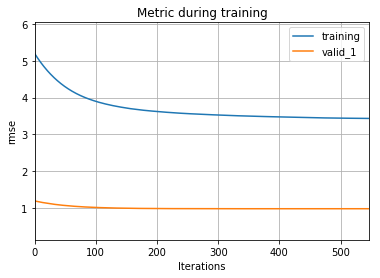

[1]	training's rmse: 5.21054	valid_1's rmse: 1.03475
Training until validation scores don't improve for 100 rounds.
[2]	training's rmse: 5.1845	valid_1's rmse: 1.03026
[3]	training's rmse: 5.15885	valid_1's rmse: 1.02582
[4]	training's rmse: 5.13359	valid_1's rmse: 1.02132
[5]	training's rmse: 5.1087	valid_1's rmse: 1.0169
[6]	training's rmse: 5.0842	valid_1's rmse: 1.01254
[7]	training's rmse: 5.06005	valid_1's rmse: 1.00816
[8]	training's rmse: 5.03629	valid_1's rmse: 1.00394
[9]	training's rmse: 5.01288	valid_1's rmse: 0.999777
[10]	training's rmse: 4.98982	valid_1's rmse: 0.995623
[11]	training's rmse: 4.96713	valid_1's rmse: 0.991597
[12]	training's rmse: 4.94479	valid_1's rmse: 0.987647
[13]	training's rmse: 4.92279	valid_1's rmse: 0.983614
[14]	training's rmse: 4.90113	valid_1's rmse: 0.979744
[15]	training's rmse: 4.87982	valid_1's rmse: 0.975947
[16]	training's rmse: 4.85883	valid_1's rmse: 0.972196
[17]	training's rmse: 4.83816	valid_1's rmse: 0.968636
[18]	training's rmse: 4

[161]	training's rmse: 3.70158	valid_1's rmse: 0.783643
[162]	training's rmse: 3.69959	valid_1's rmse: 0.783441
[163]	training's rmse: 3.69737	valid_1's rmse: 0.783223
[164]	training's rmse: 3.69541	valid_1's rmse: 0.78295
[165]	training's rmse: 3.69353	valid_1's rmse: 0.78274
[166]	training's rmse: 3.69139	valid_1's rmse: 0.782535
[167]	training's rmse: 3.68954	valid_1's rmse: 0.782337
[168]	training's rmse: 3.68774	valid_1's rmse: 0.782159
[169]	training's rmse: 3.68568	valid_1's rmse: 0.781961
[170]	training's rmse: 3.68368	valid_1's rmse: 0.781773
[171]	training's rmse: 3.68195	valid_1's rmse: 0.781583
[172]	training's rmse: 3.67999	valid_1's rmse: 0.781397
[173]	training's rmse: 3.6783	valid_1's rmse: 0.781221
[174]	training's rmse: 3.67641	valid_1's rmse: 0.78104
[175]	training's rmse: 3.67454	valid_1's rmse: 0.780862
[176]	training's rmse: 3.67292	valid_1's rmse: 0.780707
[177]	training's rmse: 3.67111	valid_1's rmse: 0.780492
[178]	training's rmse: 3.66936	valid_1's rmse: 0.780

[314]	training's rmse: 3.53195	valid_1's rmse: 0.772951
[315]	training's rmse: 3.5311	valid_1's rmse: 0.772943
[316]	training's rmse: 3.53055	valid_1's rmse: 0.772939
[317]	training's rmse: 3.52972	valid_1's rmse: 0.772937
[318]	training's rmse: 3.52919	valid_1's rmse: 0.772945
[319]	training's rmse: 3.52838	valid_1's rmse: 0.772944
[320]	training's rmse: 3.52789	valid_1's rmse: 0.772939
[321]	training's rmse: 3.52709	valid_1's rmse: 0.772938
[322]	training's rmse: 3.52652	valid_1's rmse: 0.772943
[323]	training's rmse: 3.52602	valid_1's rmse: 0.772955
[324]	training's rmse: 3.52542	valid_1's rmse: 0.77295
[325]	training's rmse: 3.52485	valid_1's rmse: 0.772944
[326]	training's rmse: 3.52437	valid_1's rmse: 0.772946
[327]	training's rmse: 3.52377	valid_1's rmse: 0.772949
[328]	training's rmse: 3.52319	valid_1's rmse: 0.772944
[329]	training's rmse: 3.52272	valid_1's rmse: 0.772944
[330]	training's rmse: 3.52214	valid_1's rmse: 0.772939
[331]	training's rmse: 3.52167	valid_1's rmse: 0.7

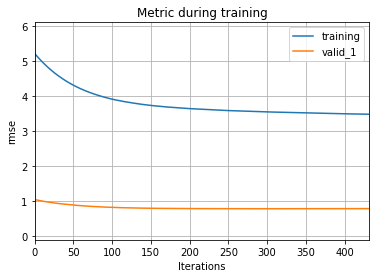

[1]	training's rmse: 0.903238	valid_1's rmse: 10.4335
Training until validation scores don't improve for 100 rounds.
[2]	training's rmse: 0.903056	valid_1's rmse: 10.4332
[3]	training's rmse: 0.902877	valid_1's rmse: 10.4329
[4]	training's rmse: 0.902701	valid_1's rmse: 10.4327
[5]	training's rmse: 0.902529	valid_1's rmse: 10.4324
[6]	training's rmse: 0.90236	valid_1's rmse: 10.4321
[7]	training's rmse: 0.902192	valid_1's rmse: 10.4318
[8]	training's rmse: 0.902028	valid_1's rmse: 10.4316
[9]	training's rmse: 0.901862	valid_1's rmse: 10.4313
[10]	training's rmse: 0.901701	valid_1's rmse: 10.4311
[11]	training's rmse: 0.901542	valid_1's rmse: 10.4308
[12]	training's rmse: 0.901386	valid_1's rmse: 10.4306
[13]	training's rmse: 0.901231	valid_1's rmse: 10.4303
[14]	training's rmse: 0.901093	valid_1's rmse: 10.4301
[15]	training's rmse: 0.900952	valid_1's rmse: 10.4298
[16]	training's rmse: 0.900809	valid_1's rmse: 10.4296
[17]	training's rmse: 0.900677	valid_1's rmse: 10.4293
[18]	trainin

[159]	training's rmse: 0.888904	valid_1's rmse: 10.4198
[160]	training's rmse: 0.888852	valid_1's rmse: 10.4197
[161]	training's rmse: 0.888798	valid_1's rmse: 10.4197
[162]	training's rmse: 0.888755	valid_1's rmse: 10.4197
[163]	training's rmse: 0.888696	valid_1's rmse: 10.4197
[164]	training's rmse: 0.888655	valid_1's rmse: 10.4197
[165]	training's rmse: 0.888597	valid_1's rmse: 10.4197
[166]	training's rmse: 0.888545	valid_1's rmse: 10.4196
[167]	training's rmse: 0.8885	valid_1's rmse: 10.4198
[168]	training's rmse: 0.88846	valid_1's rmse: 10.4198
[169]	training's rmse: 0.888409	valid_1's rmse: 10.4197
[170]	training's rmse: 0.888323	valid_1's rmse: 10.4197
[171]	training's rmse: 0.888283	valid_1's rmse: 10.4197
[172]	training's rmse: 0.888216	valid_1's rmse: 10.4198
[173]	training's rmse: 0.888174	valid_1's rmse: 10.4198
[174]	training's rmse: 0.888089	valid_1's rmse: 10.4198
[175]	training's rmse: 0.888047	valid_1's rmse: 10.4198
[176]	training's rmse: 0.887982	valid_1's rmse: 10.

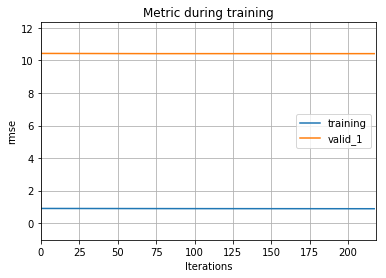

Wall time: 15min 41s


In [21]:
%%time
pred_test_full = 0
kf = KFold(n_splits=5, random_state=700)
for train_index, test_index in kf.split(train_X, train_y):

    val_train_X, val_test_X = train_X.loc[train_index,:], train_X.loc[test_index,:]
    val_train_y, val_test_y = train_y[train_index], train_y[test_index]
    
    pred_dev,pred_test,model = runLGB(val_train_X, val_train_y, val_test_X, val_test_y)
    pred_test = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_full += pred_test

pred_test_full /= 5.

In [22]:
test_df["Quantity"] = pred_test_full

In [23]:
t2 = test_df
t2 = t2.sort_values([USER_ID_COL,"Quantity"],ascending=[True,False])
t2["seq"] = t2.groupby([USER_ID_COL])["Quantity"].cumcount()
t2 = t2.loc[t2["seq"] <= 9 ,:]
sub2 = t2.groupby(USER_ID_COL)[PROD_ID_COL].apply(list).reset_index()
sub2.columns = ['UserId', 'product_list']
print(sub2.shape)

(2350, 2)


In [24]:
sub2.head(20)

,UserId,product_list
0,2,"[12371282, 12371276, 11659004, 11360668, 11360..."
1,28,"[12371282, 12371276, 11659004, 11360668, 11360..."
2,36,"[12371282, 12371276, 11659004, 11360668, 11360..."
3,38,"[12371282, 12371276, 11659004, 11360668, 11360..."
4,41,"[12371282, 12371276, 11659004, 11360668, 11360..."
5,52,"[12371282, 12371276, 11659004, 11360668, 11360..."
6,67,"[12371282, 12371276, 11659004, 11360668, 11360..."
7,69,"[12371282, 12371276, 11659004, 11360668, 11360..."
8,80,"[12371282, 12371276, 11659004, 11360668, 11360..."
9,97,"[12371282, 12371276, 11659004, 11360668, 11360..."


In [25]:
def comb_list(l1,l2):
    final = l1
    for x in l2:
        if (x not in l1) & (len(final) < 10):
            final.append(x)
    return(final)

In [27]:
test_join = pd.read_csv(PATH_TEST)

In [28]:
t2 = train_df.sort_values([USER_ID_COL,PROD_ID_COL,"Quantity"],ascending=[True,True,False])
t2 = t2.groupby([USER_ID_COL,PROD_ID_COL])["Quantity"].sum().reset_index()
t2 = t2.sort_values([USER_ID_COL,"Quantity"],ascending=[True,False])
t2["seq"] = t2.groupby([USER_ID_COL])["Quantity"].cumcount()
t2 = t2.loc[t2["seq"] <= 9 ,:]
sub_train = t2.groupby(USER_ID_COL)[PROD_ID_COL].apply(list).reset_index()
test_df[USER_ID_COL] = test_df[USER_ID_COL].astype('int64')
sub_train = pd.merge(test_join,sub_train)
#sub_train.columns = ['UserId', 'product_list']
sub_train.head()

,UserId,productid
0,2,[11660064]
1,28,"[12360404, 13039778, 11659838, 12407652, 12407..."
2,36,"[11460916, 12360448, 12407648]"
3,38,"[11659712, 11659798, 12406972]"
4,41,[11659236]


In [29]:
sub4 = sub_train
sub4["p2"] = sub2["product_list"]
sub4.head()

,UserId,productid,p2
0,2,[11660064],"[12371282, 12371276, 11659004, 11360668, 11360..."
1,28,"[12360404, 13039778, 11659838, 12407652, 12407...","[12371282, 12371276, 11659004, 11360668, 11360..."
2,36,"[11460916, 12360448, 12407648]","[12371282, 12371276, 11659004, 11360668, 11360..."
3,38,"[11659712, 11659798, 12406972]","[12371282, 12371276, 11659004, 11360668, 11360..."
4,41,[11659236],"[12371282, 12371276, 11659004, 11360668, 11360..."


In [30]:
sub4["product_list"] = sub4.apply(lambda x: comb_list(x['productid'], x['p2']), axis=1)
sub4.drop(["productid","p2"],axis=1,inplace=True)
sub4.head()

,UserId,product_list
0,2,"[11660064, 12371282, 12371276, 11659004, 11360..."
1,28,"[12360404, 13039778, 11659838, 12407652, 12407..."
2,36,"[11460916, 12360448, 12407648, 12371282, 12371..."
3,38,"[11659712, 11659798, 12406972, 12371282, 12371..."
4,41,"[11659236, 12371282, 12371276, 11659004, 11360..."


In [31]:
print(sub4.shape)
sub4.to_csv("sub_final.csv",index=False)

(2350, 2)


Public LB score = 0.0252526736